In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import cortex
import operator
import scipy.io as scio

from math import sqrt
from functools import reduce
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

In [2]:
def zscore(x):
    return x / (torch.norm(x, dim=-1, keepdim=True) + 1e-10)

def make_delayed(stim, delays, circpad=False):
    nt,ndim = stim.shape
    dstims = []
    for _, d in enumerate(delays):
        dstim = torch.zeros((nt, ndim))
        if d<0:
            dstim[:d,:] = stim[-d:,:]
            if circpad:
                dstim[d:,:] = stim[:-d,:]
        elif d>0:
            dstim[d:,:] = stim[:-d,:]
            if circpad:
                dstim[:d,:] = stim[-d:,:]
        else:
            dstim = stim.copy()
        dstims.append(dstim)
    return torch.hstack(dstims)

def contains_digit(s):
    return any(char.isdigit() for char in s)

In [3]:
train_x = make_delayed(torch.load("data/train_x.pt"), [1, 2, 3, 4, 5, 6])
train_y = torch.load("data/train_y.pt")
val_x = make_delayed(torch.load("data/val_x.pt"), [1, 2, 3, 4, 5, 6])
val_y = torch.load("data/val_y.pt")
alphas = torch.logspace(1, 20, 10).to(torch.float32)
bestResult = -10.0
bestWeights = []
bestAlpha = 0

for alpha in alphas:
    weights = torch.matmul(torch.linalg.inv(torch.matmul(train_x.T, train_x) + alpha * torch.eye(train_x.shape[1])), torch.matmul(train_x.T, train_y))
    predictions = val_x @ weights
    corr = torch.diag(torch.matmul(zscore(predictions), zscore(val_y).T)).mean(dim=0)
    print(corr)
    if corr > bestResult:
        bestResult = corr
        bestWeights = weights
        bestAlpha = alpha

del train_x, train_y, val_x, val_y

tensor(0.0113)
tensor(0.0272)
tensor(0.0324)
tensor(0.0324)
tensor(0.0324)
tensor(0.0324)
tensor(0.0307)
tensor(0.0042)
tensor(3.7980e-05)
tensor(2.9446e-07)


In [4]:
test_x = make_delayed(torch.load("data/test_x.pt"), [1, 2, 3, 4, 5, 6])
test_y = torch.load("data/test_y.pt")

ndelays = 6
udwt = reduce(operator.add, np.split(bestWeights/ndelays, ndelays))

predictions = torch.matmul(test_x, bestWeights)
corr = torch.tensor([pearsonr(predictions[:, i], test_y[:, i])[0] for i in range(udwt.shape[1])])

sortVox = torch.argsort(-corr)
maxwt = udwt[:, sortVox[:18000]]

corr = corr.numpy()

In [5]:
pca = PCA(n_components=300, svd_solver='full')
pca.fit(maxwt.T)
components = torch.from_numpy(pca.components_).to(torch.float32)
pca = torch.matmul(components, maxwt)[:4, :]

In [6]:
mask = cortex.db.get_mask('S1', 'fullhead', 'thick')

Started server on port 9877


<WebApp(Thread-4, started 131027842180672)>

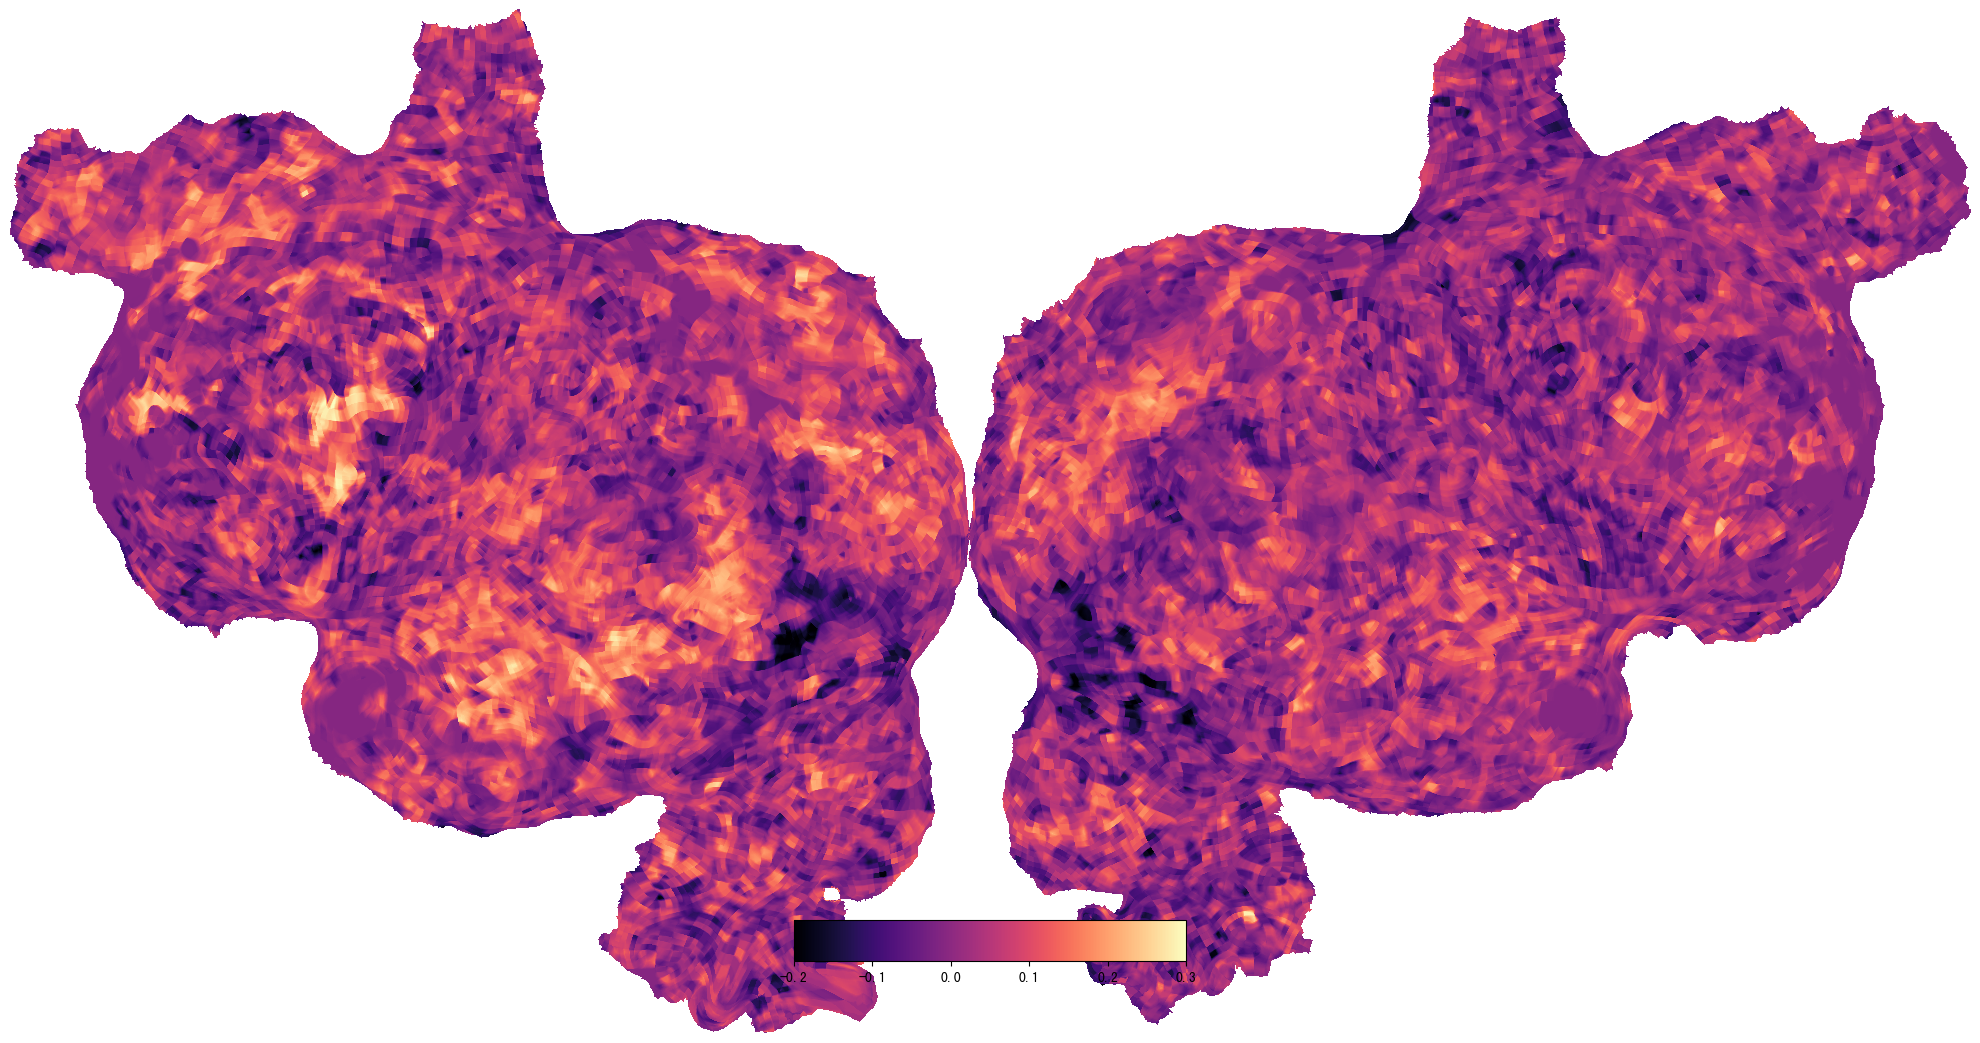

In [7]:
corrvol = cortex.Volume(corr, "S1", "fullhead", mask=mask, vmin=-0.2, vmax=0.3, cmap='magma')
cortex.quickshow(corrvol, with_rois=False, with_labels=True)
cortex.webshow(corrvol, port=9877, open_browser=False)

Background RRGGBBAA: ffffff00
Area 0:0:1960.5:1024 exported to 1960 x 1024 pixels (96 dpi)
Started server on port 2470


<WebApp(Thread-6, started 131027798324800)>

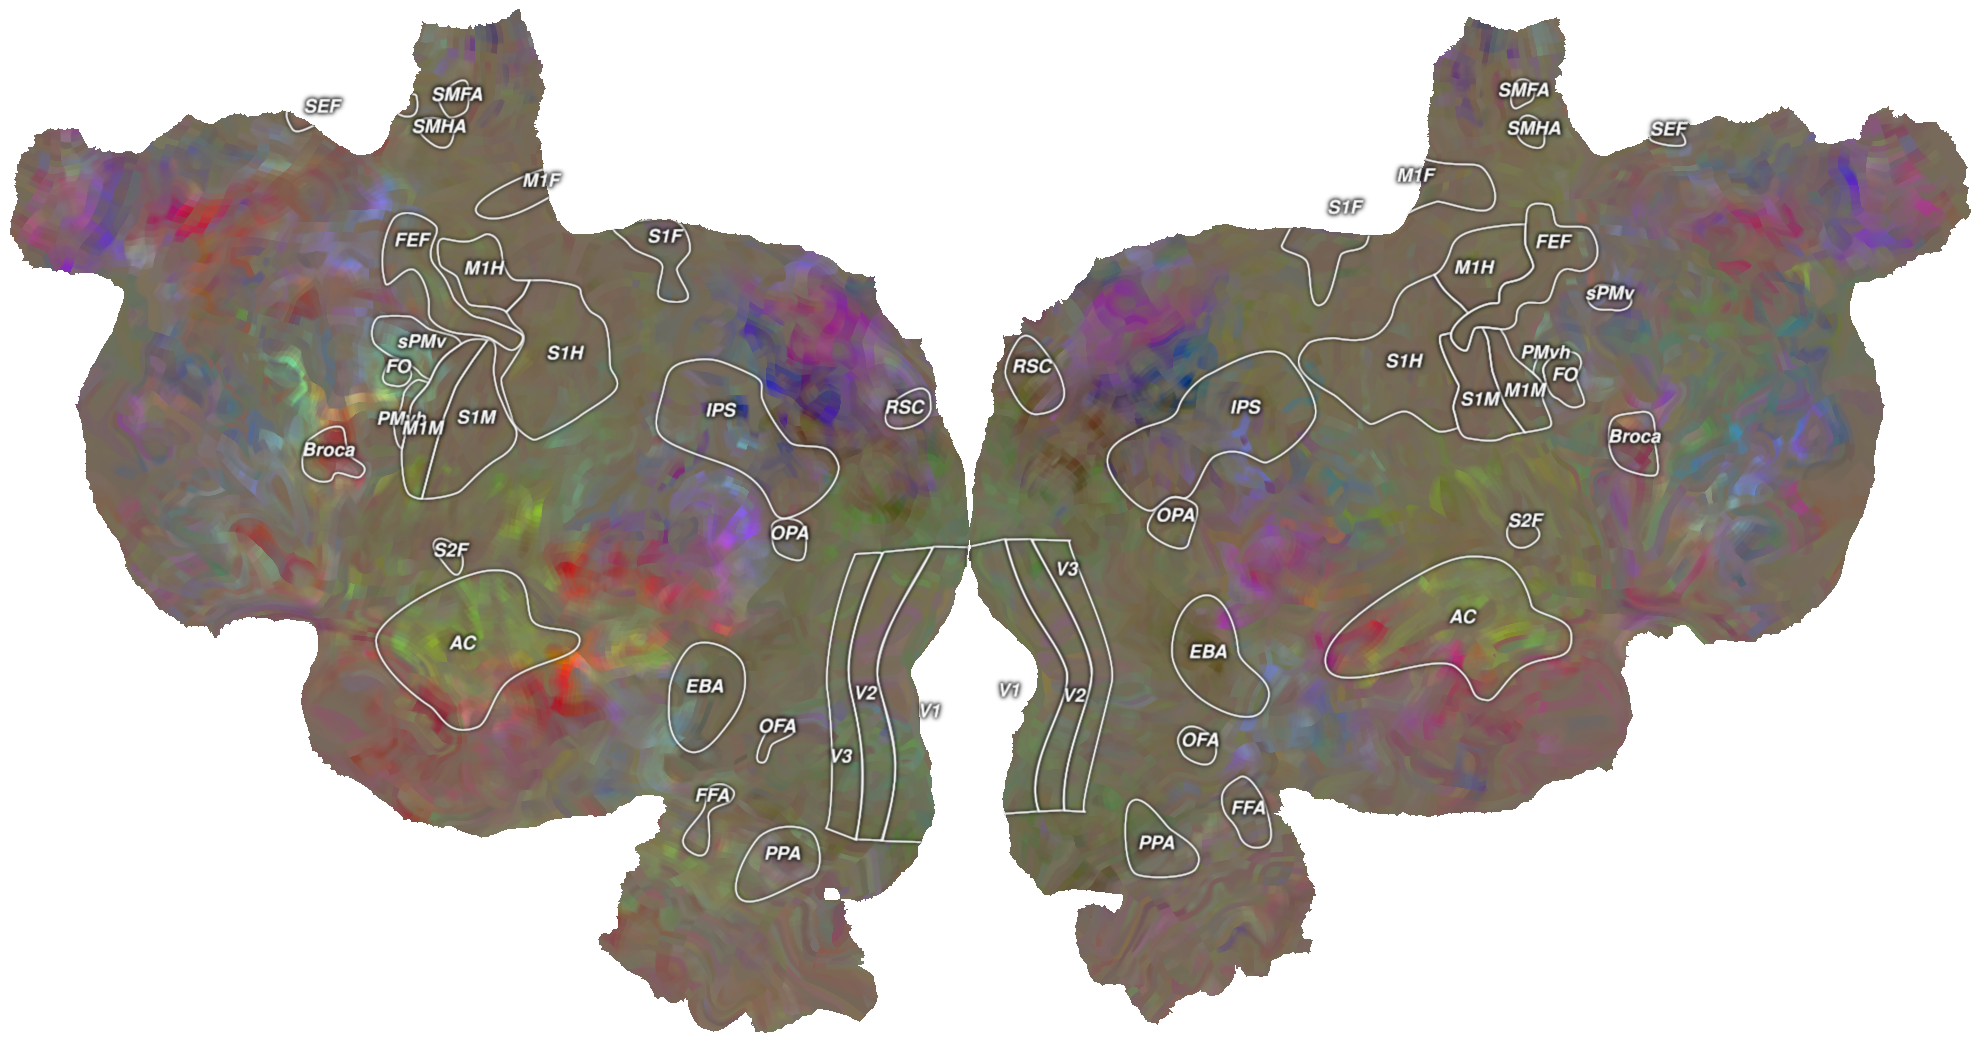

In [8]:
from scipy.interpolate import interp1d

small, big = min(sortVox[:18000]), max(sortVox[:18000])
index_array = torch.arange(big - small + 1) + small

test1 = np.zeros([80615])
f = interp1d(sortVox[:18000], pca[0, :])
test1[index_array] = f(index_array)
test2 = np.zeros([80615])
f = interp1d(sortVox[:18000], pca[1, :])
test2[index_array] = f(index_array)
test3 = np.zeros([80615])
f = interp1d(sortVox[:18000], pca[2, :])
test3[index_array] = f(index_array)

test1_scaled = (test1 - np.min(test1)) / (np.max(test1) - np.min(test1)) * 255
test2_scaled = (test2 - np.min(test2)) / (np.max(test2) - np.min(test2)) * 255
test3_scaled = (test3 - np.min(test3)) / (np.max(test3) - np.min(test3)) * 255

red = cortex.Volume(test1_scaled.astype(np.uint8), 'S1', 'fullhead', mask=mask)
green = cortex.Volume(test2_scaled.astype(np.uint8), 'S1', 'fullhead', mask=mask)
blue = cortex.Volume(test3_scaled.astype(np.uint8), 'S1', 'fullhead', mask=mask)

vol_data = cortex.VolumeRGB(red, green, blue, "S1", "fullhead")
cortex.quickshow(vol_data, with_colorbar=False)
cortex.webshow(vol_data, port=2470, open_browser=False)

In [9]:
volumes = {
    'Corr': corrvol,
    'RGB': vol_data,
}

cortex.webgl.show(data=volumes, port=1357, open_browser=False)
cortex.webgl.make_static(outpath="finalplot", data=volumes, recache=True)

Started server on port 1357


Generating new ctm file...
wm
wm
inflated
inflated


In [10]:
predictions2 = torch.matmul(test_x, bestWeights[:, sortVox[:18000]])
corr = torch.diag(torch.matmul(zscore(predictions2), zscore(test_y[:, sortVox[:18000]]).T)).mean(dim=0)
corr

tensor(0.0980)

In [11]:
bad_words = []
with open("stop_words.txt", "r", encoding="utf-8") as stopTxt:
    line = stopTxt.readline()
    while line:
        line = line.strip()
        if line != '':
            line = line.replace('\n', '')
            bad_words.append(line)
            line = stopTxt.readline()
        else:
            line = stopTxt.readline()

wordSet = set()
for story in range(1, 61):
    res = scio.loadmat("/home/public/public/CASdata/metadata/stimuli/annotations/time_align/word-level/story_" + str(story) + "_word_time.mat")
    for j in range(res['start'].shape[1]):
        if (res['word'][j].strip() not in bad_words) and (len(res['word'][j].strip()) > 1) and not (contains_digit(res['word'][j].strip())):
            wordSet.add(res['word'][j].strip())

wordDict = {}
for word in wordSet:
    wordDict[word] = [torch.zeros([300]), 0]

for story in range(1, 61):
    res = scio.loadmat("/home/public/public/CASdata/metadata/stimuli/annotations/time_align/word-level/story_" + str(story) + "_word_time.mat")
    embs = scio.loadmat("/home/public/public/CASdata/metadata/stimuli/annotations/embeddings/word2vec/word-level/300d/story_" + str(story) + "_word_word2vec.mat")["data"]
    for j in range(res['start'].shape[1]):
        if (res['word'][j].strip() not in bad_words) and (len(res['word'][j].strip()) > 1) and not (contains_digit(res['word'][j].strip())):
            wordDict[res['word'][j].strip()][0] += embs[j]
            wordDict[res['word'][j].strip()][1] += 1

final_words = []
for word in wordSet:
    final_words.append((word, wordDict[word][0] / wordDict[word][1]))

In [12]:
simi = []
coor1, coor2, coor3 = components[0, :].numpy(), components[1, :].numpy(), components[2, :].numpy()
for zipword in final_words:
    emb = zipword[1]
    simi.append(sqrt(np.dot(coor1, emb)**2 + np.dot(coor2, emb)**2 + np.dot(coor3, emb)**2))

sortWords = np.argsort(simi)
finalfinal = []
for i in sortWords[-200:]:
    finalfinal.append(final_words[i])

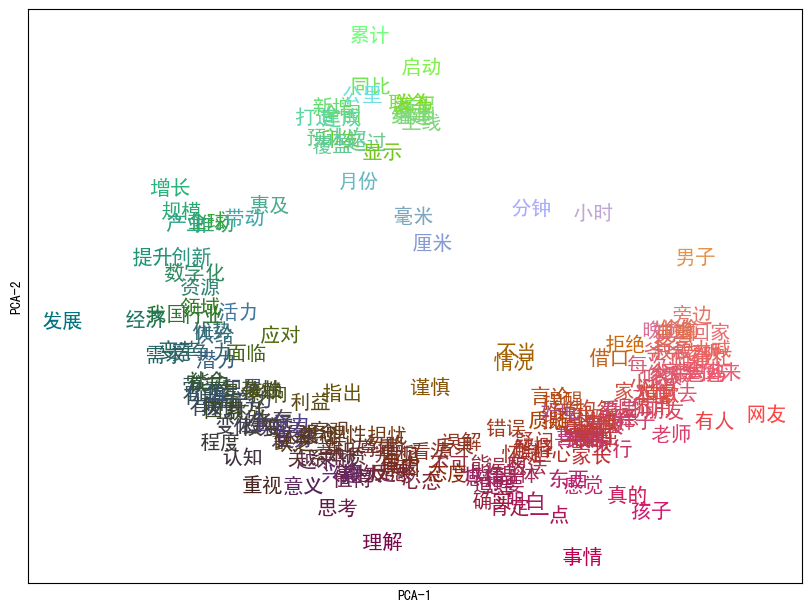

In [13]:
coor1, coor2, coor3 = components[0, :].numpy(), components[1, :].numpy(), components[2, :].numpy()
x_coor = []
y_coor = []
z_coor = []
x_rate = []
y_rate = []
dist = []

for i in range(len(finalfinal)):
    x_coor.append(np.dot(coor1, finalfinal[i][1]))
    y_coor.append(np.dot(coor2, finalfinal[i][1]))
    z_coor.append(np.dot(coor3, finalfinal[i][1]))

x_min, x_max = min(x_coor), max(x_coor)
y_min, y_max = min(y_coor), max(y_coor)
z_min, z_max = min(z_coor), max(z_coor)

word_seqs = []
for i in range(len(finalfinal)):
    word_seqs.append(finalfinal[i][0])

for i in range(len(word_seqs)):
    x_rate.append((x_coor[i] - x_min) / (x_max - x_min) * 1.0)
    y_rate.append((y_coor[i] - y_min) / (y_max - y_min) * 1.0)
    dist.append(sqrt(x_coor[i] ** 2 + y_coor[i] ** 2))

dist_min, dist_max = min(dist), max(dist)

plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=1)
plt.xticks([])
plt.yticks([])
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
for w, x, y, z in zip(word_seqs, x_coor, y_coor, z_coor): 
    ax.plot((x,),(y,), 'o', c='white') # c=(0.0, 0.0, 1.0, 1.0)
    ax.annotate(w, (x, y), ha='center', va='center',  c=((x - x_min) / (x_max - x_min) * 1.0, (y - y_min) / (y_max - y_min) * 1.0, (z - z_min) / (z_max - z_min) * 1.0, 1.0), fontsize=15) #alpha=dist_min * 5 / dist[i]

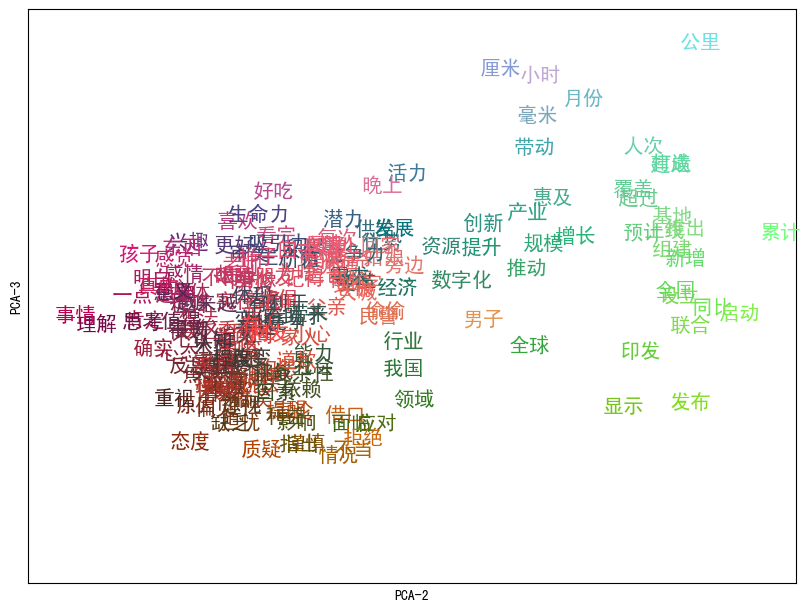

In [14]:
coor1, coor2, coor3 = components[0, :].numpy(), components[1, :].numpy(), components[2, :].numpy()
x_coor = []
y_coor = []
z_coor = []
x_rate = []
y_rate = []
dist = []

for i in range(len(finalfinal)):
    x_coor.append(np.dot(coor1, finalfinal[i][1]))
    y_coor.append(np.dot(coor2, finalfinal[i][1]))
    z_coor.append(np.dot(coor3, finalfinal[i][1]))

x_min, x_max = min(x_coor), max(x_coor)
y_min, y_max = min(y_coor), max(y_coor)
z_min, z_max = min(z_coor), max(z_coor)

word_seqs = []
for i in range(len(finalfinal)):
    word_seqs.append(finalfinal[i][0])

for i in range(len(word_seqs)):
    x_rate.append((x_coor[i] - x_min) / (x_max - x_min) * 1.0)
    y_rate.append((y_coor[i] - y_min) / (y_max - y_min) * 1.0)
    dist.append(sqrt(x_coor[i] ** 2 + y_coor[i] ** 2))

dist_min, dist_max = min(dist), max(dist)

plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=1)
plt.xticks([])
plt.yticks([])
plt.xlabel("PCA-2")
plt.ylabel("PCA-3")
for w, x, y, z in zip(word_seqs, x_coor, y_coor, z_coor): 
    ax.plot((x,),(y,), 'o', c='white')
    ax.annotate(w, (y, z), ha='center', va='center',  c=((x - x_min) / (x_max - x_min) * 1.0, (y - y_min) / (y_max - y_min) * 1.0, (z - z_min) / (z_max - z_min) * 1.0, 1.0), fontsize=15) #alpha=dist_min * 5 / dist[i]

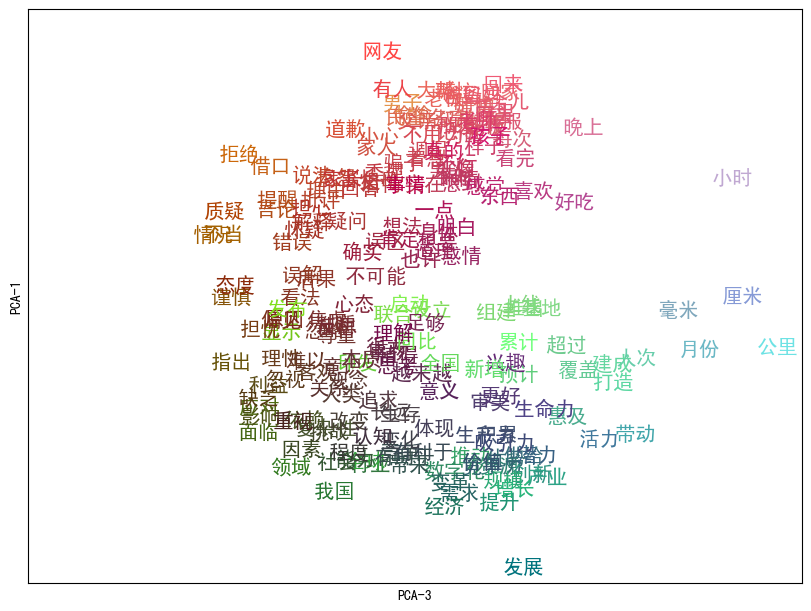

In [15]:
coor1, coor2, coor3 = components[0, :].numpy(), components[1, :].numpy(), components[2, :].numpy()
x_coor = []
y_coor = []
z_coor = []
x_rate = []
y_rate = []
dist = []

for i in range(len(finalfinal)):
    x_coor.append(np.dot(coor1, finalfinal[i][1]))
    y_coor.append(np.dot(coor2, finalfinal[i][1]))
    z_coor.append(np.dot(coor3, finalfinal[i][1]))

x_min, x_max = min(x_coor), max(x_coor)
y_min, y_max = min(y_coor), max(y_coor)
z_min, z_max = min(z_coor), max(z_coor)

word_seqs = []
for i in range(len(finalfinal)):
    word_seqs.append(finalfinal[i][0])

for i in range(len(word_seqs)):
    x_rate.append((x_coor[i] - x_min) / (x_max - x_min) * 1.0)
    y_rate.append((y_coor[i] - y_min) / (y_max - y_min) * 1.0)
    dist.append(sqrt(x_coor[i] ** 2 + y_coor[i] ** 2))

dist_min, dist_max = min(dist), max(dist)

plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=1)
plt.xticks([])
plt.yticks([])
plt.xlabel("PCA-3")
plt.ylabel("PCA-1")
for w, x, y, z in zip(word_seqs, x_coor, y_coor, z_coor): 
    ax.plot((x,),(y,), 'o', c='white')
    ax.annotate(w, (z, x), ha='center', va='center',  c=((x - x_min) / (x_max - x_min) * 1.0, (y - y_min) / (y_max - y_min) * 1.0, (z - z_min) / (z_max - z_min) * 1.0, 1.0), fontsize=15) #alpha=dist_min * 5 / dist[i]

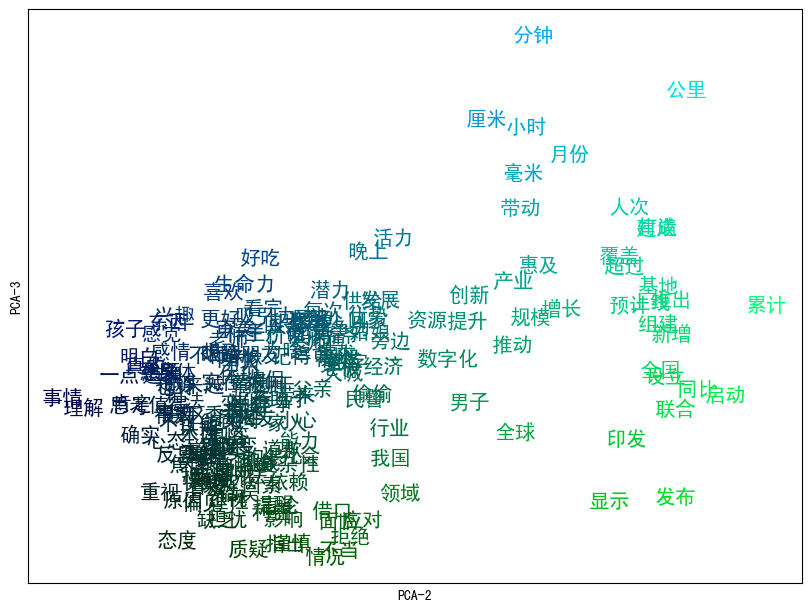

In [16]:
coor1, coor2, coor3 = components[0, :].numpy(), components[1, :].numpy(), components[2, :].numpy()
x_coor = []
y_coor = []
x_rate = []
y_rate = []
dist = []

for i in range(len(finalfinal)):
    x_coor.append(np.dot(coor2, finalfinal[i][1]))
    y_coor.append(np.dot(coor3, finalfinal[i][1]))

x_min, x_max = min(x_coor), max(x_coor)
y_min, y_max = min(y_coor), max(y_coor)

word_seqs = []
for i in range(len(finalfinal)):
    word_seqs.append(finalfinal[i][0])

for i in range(len(word_seqs)):
    x_rate.append((x_coor[i] - x_min) / (x_max - x_min) * 1.0)
    y_rate.append((y_coor[i] - y_min) / (y_max - y_min) * 1.0)
    dist.append(sqrt(x_coor[i] ** 2 + y_coor[i] ** 2))

dist_min, dist_max = min(dist), max(dist)

plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=1)
plt.xticks([])
plt.yticks([])
plt.xlabel("PCA-2")
plt.ylabel("PCA-3")
for w, x, y in zip(word_seqs, x_coor, y_coor): 
    ax.plot((x,),(y,), 'o', c='white')
    ax.annotate(w, (x, y), ha='center', va='center',  c=(0.0, (x - x_min) / (x_max - x_min) * 1.0, (y - y_min) / (y_max - y_min) * 1.0, 1.0), fontsize=15) # , alpha=dist_min * 5 / dist[i]

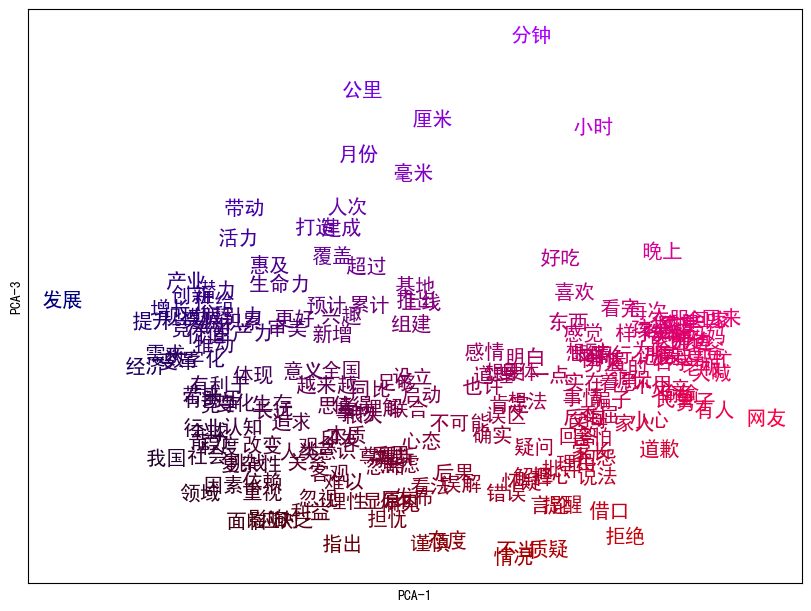

In [17]:
coor1, coor2, coor3 = components[0, :].numpy(), components[1, :].numpy(), components[2, :].numpy()
x_coor = []
y_coor = []
x_rate = []
y_rate = []
dist = []

for i in range(len(finalfinal)):
    x_coor.append(np.dot(coor1, finalfinal[i][1]))
    y_coor.append(np.dot(coor3, finalfinal[i][1]))

x_min, x_max = min(x_coor), max(x_coor)
y_min, y_max = min(y_coor), max(y_coor)

word_seqs = []
for i in range(len(finalfinal)):
    word_seqs.append(finalfinal[i][0])

for i in range(len(word_seqs)):
    x_rate.append((x_coor[i] - x_min) / (x_max - x_min) * 1.0)
    y_rate.append((y_coor[i] - y_min) / (y_max - y_min) * 1.0)
    dist.append(sqrt(x_coor[i] ** 2 + y_coor[i] ** 2))

dist_min, dist_max = min(dist), max(dist)

plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=1)
plt.xticks([])
plt.yticks([])
plt.xlabel("PCA-1")
plt.ylabel("PCA-3")
for w, x, y in zip(word_seqs, x_coor, y_coor): 
    ax.plot((x,),(y,), 'o', c='white') # c=(0.0, 0.0, 1.0, 1.0)
    ax.annotate(w, (x, y), ha='center', va='center',  c=((x - x_min) / (x_max - x_min) * 1.0, 0.0, (y - y_min) / (y_max - y_min) * 1.0, 1.0), fontsize=15) #alpha=dist_min * 5 / dist[i]